In [1]:
import os
import shutil
import random
import logging
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report

# Configure logging
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

# --- Configuration ---
# Dataset Paths
SOURCE_DATA_DIR = 'images/'       # Folder containing original class subfolders
BASE_DATA_SPLIT_DIR = 'data_split/' # Folder where split data will be stored
TRAIN_DIR = os.path.join(BASE_DATA_SPLIT_DIR, 'train')
VAL_DIR = os.path.join(BASE_DATA_SPLIT_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DATA_SPLIT_DIR, 'test')

# Split Ratios (Must sum to 1.0 as per methodology )
TRAIN_RATIO = 0.84
VAL_RATIO = 0.08
TEST_RATIO = 0.08

# Model Parameters
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCHS = 20

In [2]:
def split_dataset(source, destination, train_r, val_r, test_r, force_resplit=False):
    """
    Splits images from source into train/val/test directories in destination.
    """
    if not os.path.exists(source):
        logger.error(f"Source directory '{source}' not found. Please ensure your 'images' folder exists.")
        return

    if os.path.exists(destination) and not force_resplit:
        logger.info(f"Split directory '{destination}' already exists. Skipping re-split.")
        return

    logger.info(f"Starting dataset split from '{source}' to '{destination}'...")

    # Ensure base directories exist
    for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
        os.makedirs(d, exist_ok=True)

    class_counts = defaultdict(lambda: {'train': 0, 'val': 0, 'test': 0, 'total': 0})

    for class_name in os.listdir(source):
        class_source_path = os.path.join(source, class_name)
        if not os.path.isdir(class_source_path):
            continue

        # Create class subdirectories in split folders
        for d in [TRAIN_DIR, VAL_DIR, TEST_DIR]:
            os.makedirs(os.path.join(d, class_name), exist_ok=True)

        # Get and shuffle files
        files = [f for f in os.listdir(class_source_path) if os.path.isfile(os.path.join(class_source_path, f))]
        if not files:
            continue
        
        random.shuffle(files)
        total = len(files)
        class_counts[class_name]['total'] = total

        # Calculate split indices
        train_end = int(total * train_r)
        val_end = train_end + int(total * val_r)

        # Assign files
        splits = {
            'train': (files[:train_end], TRAIN_DIR),
            'val': (files[train_end:val_end], VAL_DIR),
            'test': (files[val_end:], TEST_DIR)
        }

        # Copy files
        for split_name, (split_files, split_dir) in splits.items():
            for file_name in split_files:
                src = os.path.join(class_source_path, file_name)
                dst = os.path.join(split_dir, class_name, file_name)
                try:
                    shutil.copy2(src, dst)
                    class_counts[class_name][split_name] += 1
                except Exception as e:
                    logger.error(f"Error copying {file_name}: {e}")

    # Log results
    logger.info("\n--- Data Split Summary ---")
    for cls, counts in class_counts.items():
         logger.info(f"{cls:<15} | Total: {counts['total']:<4} | Train: {counts['train']:<4} | Val: {counts['val']:<4} | Test: {counts['test']:<4}")
    logger.info("--------------------------")

# Execute the split
# Set force_resplit=True if you add new images and need to regenerate the splits
split_dataset(SOURCE_DATA_DIR, BASE_DATA_SPLIT_DIR, TRAIN_RATIO, VAL_RATIO, TEST_RATIO, force_resplit=False)

INFO: Split directory 'data_split/' already exists. Skipping re-split.


In [3]:
logger.info("Initializing Data Generators...")

# Training generator with data augmentation [cite: 223, 289]
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Validation/Test generator (rescaling only)
val_test_datagen = ImageDataGenerator(rescale=1./255)

try:
    # Flow from directories
    train_generator = train_datagen.flow_from_directory(
        TRAIN_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=True
    )

    validation_generator = val_test_datagen.flow_from_directory(
        VAL_DIR,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='categorical',
        shuffle=False
    )

    test_generator = val_test_datagen.flow_from_directory(
        TEST_DIR,
        target_size=IMG_SIZE,
        batch_size=1,     # Batch size 1 for accurate individual predictions during testing
        class_mode='categorical',
        shuffle=False     # Essential for consistent evaluation results
    )

    # Identify classes
    class_labels = list(train_generator.class_indices.keys())
    num_classes = len(class_labels)
    logger.info(f"Classes detected ({num_classes}): {class_labels}")

except Exception as e:
    logger.error(f"Failed to create data generators: {e}")
    logger.error("Ensure 'images' folder is populated and split_dataset has run successfully.")

INFO: Initializing Data Generators...


Found 1026 images belonging to 11 classes.
Found 93 images belonging to 11 classes.
Found 108 images belonging to 11 classes.


INFO: Classes detected (11): ['Akok', 'Cek Mek Molek', 'Ketayap', 'Kole Kacang', 'Kuih Bakar', 'Kuih Lapis', 'Kuih Lompang', 'Kuih Qasidah', 'Onde-onde', 'Pulut Sekaya', 'Seri Muka']


In [4]:
#START MODEL_TRAINING =====================================================================================================

In [5]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt
import numpy as np
import os
import logging
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report # For evaluation

# Configure logging (optional, but good practice)
logging.basicConfig(level=logging.INFO, format='%(levelname)s: %(message)s')
logger = logging.getLogger(__name__)

In [6]:
# %% [markdown]
# ## 2. Configuration
# Define constants and paths used throughout the notebook.

checkpoint = ModelCheckpoint('best_kuih_model.keras',
                             monitor='val_accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=1)

early_stop = EarlyStopping(monitor='val_loss',
                           patience=5,
                           restore_best_weights=True,
                           verbose=1)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=3,
                              min_lr=1e-6,
                              verbose=1)

# %%
# --- Data Configuration ---
IMG_SIZE = (224, 224) # Standard input size for MobileNetV2
BATCH_SIZE = 32
BASE_DATA_DIR = 'data_split/' # Base directory created by split_dataset.py
TRAIN_DIR = os.path.join(BASE_DATA_DIR, 'train')
VAL_DIR = os.path.join(BASE_DATA_DIR, 'validation')
TEST_DIR = os.path.join(BASE_DATA_DIR, 'test')

In [7]:
# --- Model Configuration ---
LEARNING_RATE = 0.001 # Initial learning rate for Adam optimizer
MODEL_SAVE_PATH = 'kuih_recognition_model.keras' # Path to save the trained model

# --- Training Configuration ---
EPOCHS_TO_TRAIN = 20 # Adjust based on performance during training

In [8]:
# %% [markdown]
# ## 3. Data Preparation (Phase 2 - Preprocessing & Splitting)
# Set up `ImageDataGenerator` to load, preprocess, and augment data from the split directories (`train`, `validation`, `test`).

# %%
logger.info("Setting up data generators from split directories...")

# [cite_start]Generator for Training (with augmentation) [cite: 178-179, 223, 775]
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,      # Increased rotation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.3,         # Increased zoom for varying distances
    horizontal_flip=True,
    vertical_flip=True,     # Useful for top-down food photos
    brightness_range=[0.8, 1.2], # ADDRESSES LIGHTING CHALLENGES
    fill_mode='nearest'
)

# Generator for Validation and Testing (only rescaling)
datagen_val_test = ImageDataGenerator(rescale=1./255)

# Check if directories exist before creating generators
if not os.path.exists(TRAIN_DIR) or not os.path.exists(VAL_DIR) or not os.path.exists(TEST_DIR):
    logger.error(f"One or more data directories ('{TRAIN_DIR}', '{VAL_DIR}', '{TEST_DIR}') not found. "
                 "Please ensure you have run the `split_dataset.py` script first.")
    raise FileNotFoundError("Data directories not found.")

# Create Training Generator
train_generator = datagen_train.flow_from_directory(
    TRAIN_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical', # For multi-class classification
    shuffle=True
)

# Create Validation Generator
validation_generator = datagen_val_test.flow_from_directory(
    VAL_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False # Typically false for validation
)

# Create Test Generator
test_generator = datagen_val_test.flow_from_directory(
    TEST_DIR,
    target_size=IMG_SIZE,
    batch_size=1, # Process one image at a time for evaluation
    class_mode='categorical',
    shuffle=False # CRUCIAL: Do not shuffle test data for evaluation
)

# --- Output Confirmation ---
if train_generator.samples == 0:
    logger.error("No training images found. Check the 'train' directory.")
    raise ValueError("No training images found.")

logger.info(f"Found {train_generator.samples} images for training in '{TRAIN_DIR}'.")
logger.info(f"Found {validation_generator.samples} images for validation in '{VAL_DIR}'.")
logger.info(f"Found {test_generator.samples} images for testing in '{TEST_DIR}'.")

num_classes = train_generator.num_classes
class_labels = list(train_generator.class_indices.keys())
logger.info(f"Detected {num_classes} classes: {class_labels}")
logger.info(f"Class Indices: {train_generator.class_indices}")

INFO: Setting up data generators from split directories...


Found 1026 images belonging to 11 classes.
Found 93 images belonging to 11 classes.
Found 108 images belonging to 11 classes.


INFO: Found 1026 images for training in 'data_split/train'.
INFO: Found 93 images for validation in 'data_split/validation'.
INFO: Found 108 images for testing in 'data_split/test'.
INFO: Detected 11 classes: ['Akok', 'Cek Mek Molek', 'Ketayap', 'Kole Kacang', 'Kuih Bakar', 'Kuih Lapis', 'Kuih Lompang', 'Kuih Qasidah', 'Onde-onde', 'Pulut Sekaya', 'Seri Muka']
INFO: Class Indices: {'Akok': 0, 'Cek Mek Molek': 1, 'Ketayap': 2, 'Kole Kacang': 3, 'Kuih Bakar': 4, 'Kuih Lapis': 5, 'Kuih Lompang': 6, 'Kuih Qasidah': 7, 'Onde-onde': 8, 'Pulut Sekaya': 9, 'Seri Muka': 10}


In [9]:
# %% [markdown]
# ## 4. Model Building (Phase 3 - Algorithm Implementation)
# [cite_start]Define and compile the CNN model using MobileNetV2 transfer learning. [cite: 824-826]

# %%
logger.info(f"Building model for {num_classes} classes using MobileNetV2 base...")

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    include_top=False, # Exclude ImageNet classifier
    weights='imagenet'
)

INFO: Building model for 11 classes using MobileNetV2 base...


In [10]:
# Freeze the base model layers
base_model.trainable = False
logger.info("MobileNetV2 base model loaded and layers frozen.")

# Add custom classification layers
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x) # Regularization
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x) # Regularization
predictions = Dense(num_classes, activation='softmax')(x) # Output layer

# Create the final model
model = Model(inputs=base_model.input, outputs=predictions)
logger.info("Custom top layers added.")

# Compile the model
optimizer = Adam(learning_rate=LEARNING_RATE)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
logger.info("Model compiled successfully.")

# Print model summary
model.summary()

INFO: MobileNetV2 base model loaded and layers frozen.
INFO: Custom top layers added.
INFO: Model compiled successfully.


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,423,371 (9.24 MB)

 Trainable params: 165,387 (646.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [11]:
# %% [markdown]
# ## 5. Model Training (Phase 3 - Algorithm Implementation)
# Train the model using the prepared data generators.

# %%
logger.info(f"Starting model training for {EPOCHS_TO_TRAIN} epochs...")

# Calculate steps per epoch
steps_per_epoch = train_generator.samples // BATCH_SIZE
validation_steps = validation_generator.samples // BATCH_SIZE

# Adjust steps if dataset size is smaller than batch size
if steps_per_epoch == 0:
    steps_per_epoch = 1
    logger.warning(f"Training dataset smaller than batch size. Setting steps_per_epoch=1.")
if validation_steps == 0 and validation_generator.samples > 0:
    validation_steps = 1
    logger.warning(f"Validation dataset smaller than batch size. Setting validation_steps=1.")

# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=50, # Increase epochs since EarlyStopping will handle stopping
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=[checkpoint, early_stop, reduce_lr] # Add callbacks here
)

logger.info("Model training completed.")

INFO: Starting model training for 20 epochs...
C:\Users\rahim\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.1882 - loss: 2.8172
Epoch 1: val_accuracy improved from -inf to 0.67188, saving model to best_kuih_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 169s 5s/step - accuracy: 0.1902 - loss: 2.8053 - val_accuracy: 0.6719 - val_loss: 1.6159 - learning_rate: 0.0010
Epoch 2/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 27s 877ms/step - accuracy: 0.4062 - loss: 1.8032

C:\Users\rahim\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()



Epoch 2: val_accuracy did not improve from 0.67188
32/32 ━━━━━━━━━━━━━━━━━━━━ 13s 386ms/step - accuracy: 0.4062 - loss: 1.8032 - val_accuracy: 0.6719 - val_loss: 1.5786 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4663 - loss: 1.6841
Epoch 3: val_accuracy improved from 0.67188 to 0.92188, saving model to best_kuih_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 211s 7s/step - accuracy: 0.4669 - loss: 1.6816 - val_accuracy: 0.9219 - val_loss: 0.6795 - learning_rate: 0.0010
Epoch 4/50
 1/32 ━━━━━━━━━━━━━━━━━━━━ 17s 570ms/step - accuracy: 0.5000 - loss: 1.1884
Epoch 4: val_accuracy did not improve from 0.92188
32/32 ━━━━━━━━━━━━━━━━━━━━ 18s 572ms/step - accuracy: 0.5000 - loss: 1.1884 - val_accuracy: 0.9062 - val_loss: 0.6763 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6275 - loss: 1.1516
Epoch 5: val_accuracy improved from 0.92188 to 0.93750, saving model to best_kuih_model.keras
32/32 ━━━━━━━━━━━━━━━━━━━━ 245s 

INFO: Model training completed.


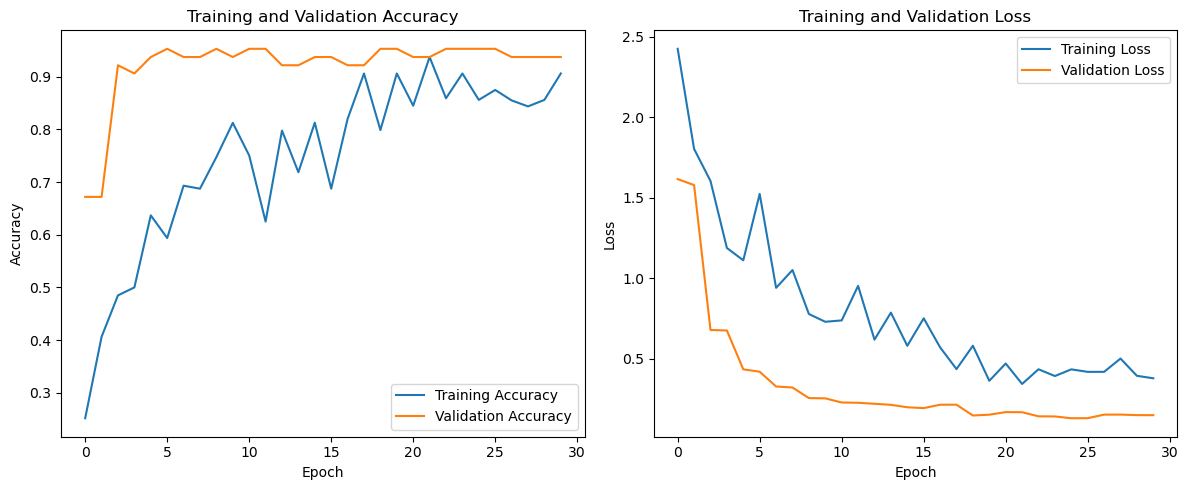

In [12]:
# %% [markdown]
# ## 6. Visualize Training History
# Plot accuracy and loss curves for training and validation sets.

# %%
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# FIX: Dynamically determine the range based on actual training length
actual_epochs = len(acc)
epochs_range = range(actual_epochs)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()

In [13]:
# %% [markdown]
# ## 7. Save the Trained Model
# Save the model to a file for later use in the web application.

# %%
try:
    model.save(MODEL_SAVE_PATH)
    logger.info(f"Trained model saved successfully to '{MODEL_SAVE_PATH}'")
except Exception as e:
    logger.error(f"Error saving model: {e}")

INFO: Trained model saved successfully to 'kuih_recognition_model.keras'


INFO: Evaluating model on the test set...


108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 80ms/step - accuracy: 0.9327 - loss: 0.2315


INFO: Test Loss: 0.1885
INFO: Test Accuracy: 0.9444


108/108 ━━━━━━━━━━━━━━━━━━━━ 9s 84ms/step


INFO: 
--- Classification Report ---


               precision    recall  f1-score   support

         Akok       0.89      0.89      0.89         9
Cek Mek Molek       1.00      1.00      1.00         3
      Ketayap       0.94      1.00      0.97        16
  Kole Kacang       1.00      1.00      1.00        10
   Kuih Bakar       0.89      0.89      0.89         9
   Kuih Lapis       0.90      1.00      0.95         9
 Kuih Lompang       1.00      0.92      0.96        12
 Kuih Qasidah       1.00      1.00      1.00         4
    Onde-onde       0.93      0.93      0.93        14
 Pulut Sekaya       1.00      0.90      0.95        10
    Seri Muka       0.92      0.92      0.92        12

     accuracy                           0.94       108
    macro avg       0.95      0.95      0.95       108
 weighted avg       0.95      0.94      0.94       108


INFO: 
Overall Metrics (Weighted Avg):
INFO:   Accuracy: 0.9444
INFO:   Precision: 0.9459
INFO:   Recall: 0.9444
INFO:   F1-Score: 0.9444
INFO: 
--- Confusion Matrix ---


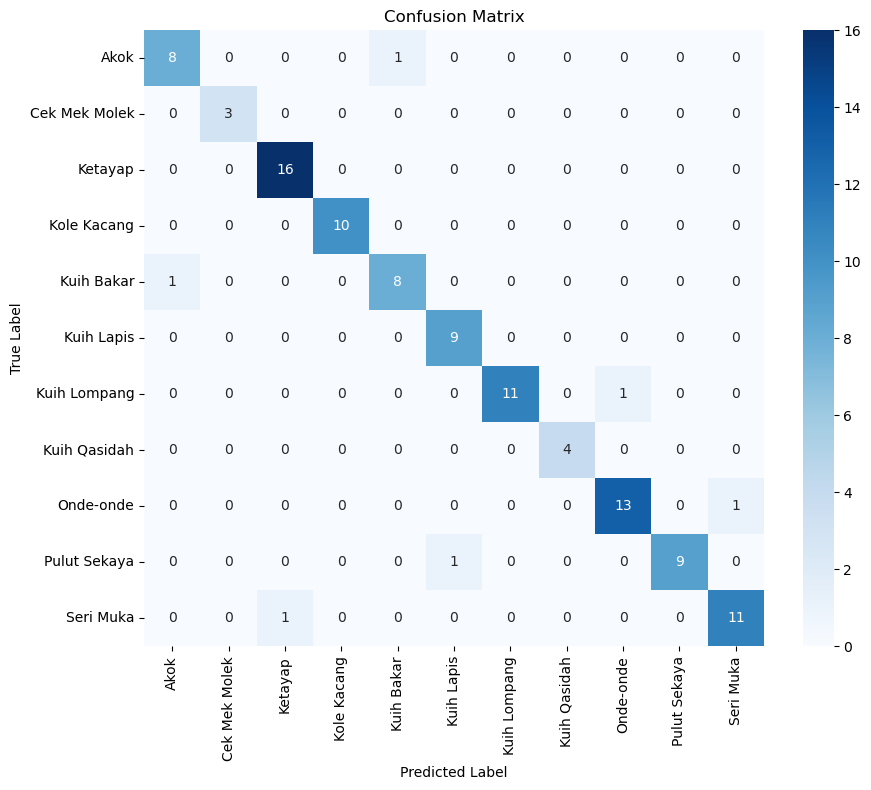

INFO: --- Performance Evaluation Finished ---
INFO: Confusion matrix saved to 'confusion_matrix_mobilenetv2.png'


<Figure size 640x480 with 0 Axes>

In [15]:
# %% [markdown]
# ## 8. Performance Evaluation (Phase 4)
# [cite_start]Evaluate the trained model on the independent test set using standard metrics. [cite: 976-978, 991]

# %%
if test_generator and test_generator.samples > 0:
    logger.info("Evaluating model on the test set...")

    # Ensure generator is reset
    test_generator.reset()

    # Evaluate loss and accuracy on the test set
    test_loss, test_acc = model.evaluate(test_generator, verbose=1) # Let Keras determine steps
    logger.info(f"Test Loss: {test_loss:.4f}")
    logger.info(f"Test Accuracy: {test_acc:.4f}")

    # Generate predictions for classification report and confusion matrix
    test_generator.reset() # Reset again before predicting
    predictions = model.predict(test_generator, steps=test_generator.samples // test_generator.batch_size)
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = test_generator.classes

    # Ensure we have the correct number of labels for the report
    target_names = list(test_generator.class_indices.keys())

    # [cite_start]Generate Classification Report [cite: 180, 876, 991-1021]
    logger.info("\n--- Classification Report ---")
    try:
        report = classification_report(true_classes, predicted_classes, target_names=target_names, zero_division=0)
        print(report)
        # [cite_start]Extract overall metrics mentioned in the proposal [cite: 180, 991]
        report_dict = classification_report(true_classes, predicted_classes, target_names=target_names, output_dict=True, zero_division=0)
        accuracy = report_dict['accuracy']
        precision = report_dict['weighted avg']['precision']
        recall = report_dict['weighted avg']['recall']
        f1_score = report_dict['weighted avg']['f1-score']
        logger.info(f"\nOverall Metrics (Weighted Avg):")
        logger.info(f"  Accuracy: {accuracy:.4f}")
        logger.info(f"  Precision: {precision:.4f}")
        logger.info(f"  Recall: {recall:.4f}")
        logger.info(f"  F1-Score: {f1_score:.4f}")

    except ValueError as e:
        logger.error(f"Error generating classification report: {e}")
        logger.error(f"Unique true classes: {np.unique(true_classes)}")
        logger.error(f"Unique predicted classes: {np.unique(predicted_classes)}")
        logger.error(f"Target names: {target_names}")
    except Exception as e:
         logger.error(f"An unexpected error occurred during classification report generation: {e}")


    # [cite_start]Generate Confusion Matrix [cite: 231, 619, 876]
    logger.info("\n--- Confusion Matrix ---")
    try:
        cm = confusion_matrix(true_classes, predicted_classes)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=target_names, yticklabels=target_names)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('Confusion Matrix')
        plt.show()
    except Exception as e:
        logger.error(f"Error generating confusion matrix: {e}")

else:
    logger.warning("Test generator is not available or has no samples. Skipping final evaluation.")

logger.info("--- Performance Evaluation Finished ---")
plt.savefig('confusion_matrix_mobilenetv2.png')
logger.info("Confusion matrix saved to 'confusion_matrix_mobilenetv2.png'")

# %% [markdown]
# --- End of Notebook ---